# **Projet 5 - <span style="color:#1d479b">Segmentez les clients d'un site e-commerce</span>**
---

**<span style="color:#1d479b">Objectif de la mission:</span>**
* Fournir une **segmentation des clients** afin d'apporter des informations supplémentaires aux équipes pour leurs campagnes de communication.
* **Comprendre les différents types d’utilisateurs** grâce à leur comportement et à leurs données personnelles.
* Fournir une **description actionable de la segmentation** et de sa logique sous-jacente pour une utilisation optimale.
* Proposition de **contrat de maintenance basée sur une analyse de la stabilité** des segments au cours du temps..

## **0. Importation des librairies et des données**
---

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
path_customers = "C:/Users/remid/Documents/_OC_ParcoursDataScientist/P5_Segmentez_Des_Clients_Dun_Site_e_commerce/df_maintenance.csv"
df_maintenance = pd.read_csv(path_customers, sep=",")
df = df_maintenance.copy()

### **0.1 - Définition de la charte graphique**

In [3]:
["#0B28D0","#A2A2D5","#FFF","#333","#EDAD01"]

['#0B28D0', '#A2A2D5', '#FFF', '#333', '#EDAD01']

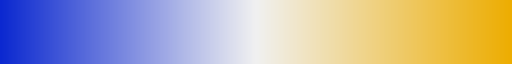

In [4]:
# Define the heatmap color
first_color = "#0B28D0"
under_color = "#F1F1F1"
over_color = "#EDAD01"
# Create a personal color map 
colors = [first_color,under_color, over_color]
n_bins = 400
cmap_name = 'custom_colormap'
heatmap_color = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
heatmap_color

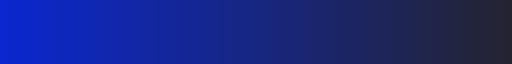

In [5]:
palette_b = sns.dark_palette("#0B28D0", reverse=True, as_cmap=True)
palette_b

In [6]:
# Colour palette for the various graphics
n_colors = 10
palette_map = sns.color_palette("dark:#0B28D0", n_colors=n_colors,as_cmap=False)
palette_map

[(0.14217064351973224, 0.14390410693260464, 0.19354284782618525),
 (0.13129638908327107, 0.14532701622135824, 0.26185663585419044),
 (0.12042213464680988, 0.14674992551011184, 0.33017042388219564),
 (0.10915951398047509, 0.1482236529877495, 0.4009239900540581),
 (0.0982852595440139, 0.1496465622765031, 0.4692377780820633),
 (0.08702263887767911, 0.15112028975414074, 0.5399913442539259),
 (0.07614838444121794, 0.15254319904289435, 0.6083051322819311),
 (0.06488576377488314, 0.154016926520532, 0.6790586984537935),
 (0.05401150933842197, 0.1554398358092856, 0.7473724864817987),
 (0.043137254901960784, 0.1568627450980392, 0.8156862745098039)]

### **0.2 - Normalisation de l'affichage des graphiques**

In [7]:
# Defines display options for rows and columns
pd.set_option('display.max_row',100)
pd.set_option('display.max_column',100)

In [8]:
# Defines title formatting
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titlecolor'] = '#000'
plt.rcParams['axes.titlepad'] = 20
# Defines axis formatting
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelcolor'] = '#EDAD01'
#Defines scale formatting
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8 
plt.rcParams['xtick.color'] = '#333'
plt.rcParams['ytick.color'] = '#333'

In [9]:
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2,
              rc={"axes.titlesize":16, 
                  "axes.labelsize":10, 
                  "xtick.labelsize":8, 
                  "ytick.labelsize":8, 
                  "xtick.color":"#333", 
                  "ytick.color":"#333", 
                  "axes.titlecolor":"#000", 
                  "axes.labelcolor":"#EDAD01"
                  })

## **1. Traitement des données**
***

La colonne `order_purchase_timestamp` est passée au format datetime afin de gérer plus facilement la notion de temps. 

In [10]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

Les colonnes inutiles sont supprimées et les données sont triées par ordre décroissant.

In [11]:
df.drop(columns=["order_delivered_customer_date","customer_zip_code_prefix","customer_city","days_since_last_order"], inplace=True)

In [12]:
df = df.sort_values(by="order_purchase_timestamp")

## **2. Clustering**
***

#### **2.1 Période de référence (17 mois)**

Afin d'avoir une base de comparaison, un premier clustering est effectué sur les données issues de la première années de commandes. Les résultats n'étant pas satisfaisants, plusieurs périodes ont été testés et les résultats les plus pertinents mènent à une période référence de 17 mois. 

Pour commencer, la plus ancienne commande est instanciée dans la variable `oldest_date` et la date d'anniversaire (17 mois) est instanciée dans la variable `one_year_later`. Ces variables serviront a sélectionner "automatiquement" une période de 17 moisn à compter de la première commande disponible.

In [13]:
oldest_date = df['order_purchase_timestamp'].min()
one_year_later = oldest_date + pd.DateOffset(months=17)

Les données sont maintenant isolée dans un nouveau DF afin d'effectuer le clustering de référence.

In [14]:
data_ref = df[(df['order_purchase_timestamp'] >= oldest_date) & (df['order_purchase_timestamp'] <= one_year_later)]

Création d'un DF `df_nb_orders_per_customer` contenant le nombre de commande par client.

In [15]:
df_nb_orders_per_customer = data_ref.groupby(by="customer_unique_id").count()[["order_id"]].reset_index()
df_nb_orders_per_customer.rename(columns={"order_id":"nb_orders_per_customer"}, inplace=True)
# Delete column
data_ref = data_ref.drop(columns="order_id")

Les données sont maintenant regroupées par client et aggréger de manière a obtenir la moyenne par client pour chacune des variables. Les individus ayant des valeurs manquantes sont supprimés.

In [16]:
data_ref = data_ref.groupby(by="customer_unique_id").mean().reset_index().dropna()

Le nombre de commande par client ainsi que la récence sont ajoutés au data set.

In [17]:
data_ref = data_ref.merge(df_nb_orders_per_customer, on="customer_unique_id", how="left")

In [18]:
data_ref['days_since_last_order'] = (data_ref["order_purchase_timestamp"].max() - data_ref['order_purchase_timestamp']).dt.days

Les colonnes inutiles au clustering sont écartées.

In [19]:
data_ref = data_ref.loc[:,["review_score", "payment_installments", "average_price", "days_since_last_order", "nb_orders_per_customer"]]

Les données sont standardisées avant le clustering et instancié dans la variable `data_ref_scaled`.

In [20]:
sc_ref = StandardScaler()
data_ref_scaled = sc_ref.fit_transform(data_ref)

La phase de modélisation a permit d'identifier le modèle `KMeans` comme le plus pertinent pour segmenter les clients. Cette phase a également permit d'identifier qu'une `segmentation en 5 clusters` était la plus pertinente sur l'ensemble des données, c'est donc ces éléments qui sont utilisés pour évaluer l'évolution des clusters dans le temps.

Le `KMeans` est paramétré et instancié dans la variable `kmeans_ref` puis appliqué aux données standardisées `data_ref`.

In [21]:
kmeans_ref = KMeans(n_clusters=5, n_init="auto", random_state=42)
kmeans_ref.fit(data_ref_scaled)

KMeans(n_clusters=5, n_init='auto', random_state=42)

Enfin, les labels de cluster pour chaque point de données sont instanciés dans la variable `clusters`. Ces résultats serviront de base de comparaison avec les autres clustering afin de mesurer leurs qualité.

In [22]:
clusters = kmeans_ref.labels_

#### **2.2 Evolution des clusters dans le temsp (ARI)**

L'analyse de stabilité du clustering s'effectue via le score ARI. 

Pour cela, il est nécessaire de comparer les clusters pour les différentes périodes, soit toutes les semaines à compter de la première année (période de référence). Il s'agit d'utiliser les résultats obtenus via le modèle de référence (méthode `prédict()`) et ceux obtenus par le modèle générer à partir de ces nouvelles données.

Afin que les résultats soient comparables, le traitement des données sera identique à ceux mis en place pour la période de référence.

In [23]:
# Define total number of weeks
total_weeks = int((df['order_purchase_timestamp'].max() - one_year_later).days // 7)
# Create a list to store ARI scores
ari_scores = []

# Create a loop for each week
for week in range(total_weeks):
    
    # Filter data for this sliding window
    data_current_window = df[(df['order_purchase_timestamp'] >= oldest_date) & (df['order_purchase_timestamp'] <= one_year_later)]
    
    # Counts the number of orders per customer and renames the column
    df_nb_orders_per_customer = data_current_window.groupby(by="customer_unique_id").count()[["order_id"]].reset_index()
    df_nb_orders_per_customer.rename(columns={"order_id":"nb_orders_per_customer"}, inplace=True)
    # Deletes unnecessary column
    data_current_window = data_current_window.drop(columns="order_id")
    
    # Adds recency by customer
    data_current_window['days_since_last_order'] = (data_current_window["order_purchase_timestamp"].max() - data_current_window['order_purchase_timestamp']).dt.days
    # Obtains the average value of orders per customer
    data_current_week = data_current_window.groupby(by="customer_unique_id").mean().reset_index().dropna()
    # Adds the number of orders per customer
    data_current_week = data_current_week.merge(df_nb_orders_per_customer, on="customer_unique_id", how="left")
    # Selects relevant columns for clustering
    data_current_week = data_current_week.loc[:,["review_score", "payment_installments", "average_price", "days_since_last_order", "nb_orders_per_customer"]]

    # Standardize and adjust data
    sc = StandardScaler()
    data_scaled = sc.fit_transform(data_current_week)
    # Initializes KMeans and adjusts data for clustering
    kmeans_week = KMeans(n_clusters=5, n_init="auto", random_state=42)
    kmeans_week.fit(data_scaled)
    # Get cluster labels for each data point
    clusters_ = kmeans_week.labels_
    
    # Adjusts the new data with the reference period's StandardScaler
    data_scaled = sc_ref.transform(data_current_week)
    # Calculates the ARI score by comparing the clustering results with those of the reference period.
    score = adjusted_rand_score(kmeans_ref.predict(data_scaled), clusters_)

    # Records the ARI score for each week
    ari_scores.append({'Period': f"du {oldest_date.date()} au {one_year_later.date()}", 'Week': week, 'ARI Score': score})

    # Displays ARI results for each period
    print(f"Semaine {week} - Score pour la période du {oldest_date.date()} au {one_year_later.date()}: {score}")

    # Add a week to the sliding window
    one_year_later += pd.DateOffset(weeks=1)

# Convert list to DataFrame
ari_scores = pd.DataFrame(ari_scores)

Semaine 0 - Score pour la période du 2016-09-04 au 2018-02-04: 1.0
Semaine 1 - Score pour la période du 2016-09-04 au 2018-02-11: 0.7827612015193349
Semaine 2 - Score pour la période du 2016-09-04 au 2018-02-18: 0.7942456567759745
Semaine 3 - Score pour la période du 2016-09-04 au 2018-02-25: 0.7943083290741372
Semaine 4 - Score pour la période du 2016-09-04 au 2018-03-04: 0.9118392402299864
Semaine 5 - Score pour la période du 2016-09-04 au 2018-03-11: 0.7489050948972377
Semaine 6 - Score pour la période du 2016-09-04 au 2018-03-18: 0.6656930884298516
Semaine 7 - Score pour la période du 2016-09-04 au 2018-03-25: 0.6613568259721317
Semaine 8 - Score pour la période du 2016-09-04 au 2018-04-01: 0.7107013203236169
Semaine 9 - Score pour la période du 2016-09-04 au 2018-04-08: 0.6954622032936753
Semaine 10 - Score pour la période du 2016-09-04 au 2018-04-15: 0.6829651154162848
Semaine 11 - Score pour la période du 2016-09-04 au 2018-04-22: 0.563517659644481
Semaine 12 - Score pour la pér

Les scores ARI sont analysés afin d'identier la dernière période qui respecte un seuil de 0.70, à partir duquel il est jugé nécessaire d'effectuer un nouveau clustering.

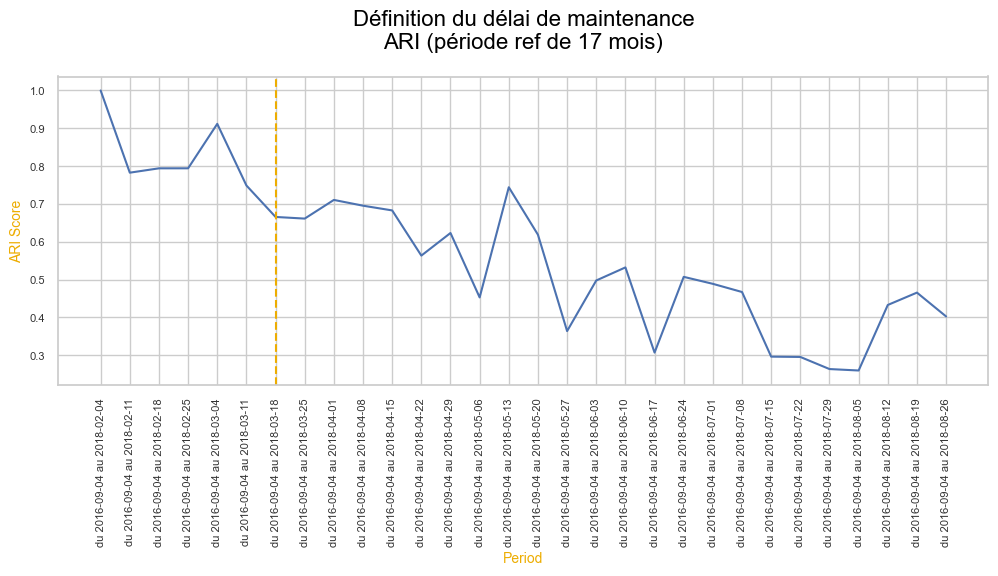

In [26]:
# Selects the last individual to meet the threshold set at 0.80
last_point = ari_scores[ari_scores['ARI Score'] <= 0.70].iloc[0]['Period']

plt.figure(figsize=(12,4))
sns.lineplot(data=ari_scores, x="Period", y="ARI Score")
plt.axvline(x=last_point, color='#EDAD01', linestyle='--')  # Ajoute une ligne verticale à x=last_point
plt.title("Définition du délai de maintenance\nARI (période ref de 17 mois)")
plt.xticks(rotation=90)
plt.show()

## **3. Résultat**
***

Les résultats montrent qu'il serait nécessaire d'effectuer une maintenance toutes les 6 à 8 semaines maximum pour que la segmentation des clients reste pertinente. 

---